# Diploar Interaction for spectrum simu and relaxation


In [33]:
# write Spatial part of the spherical harmonics for dipolar interaction with axis along z, only rank=2, other is  zero
import sympy as sp
from sympy.physics.quantum.spin import Rotation

# note: when we need study both CSA and Dipolar, T_2m need to be calculated in the principal axis system of the CSA tensor

T_2m = {
    -2: 0,
    -1: 0,
    0: sp.sqrt(3/2) * (-2),
    1: 0,
    2: 0
}
# define the Wigner D-matrix elements for rank l=2 
# using the sympy Rotation module
# def D_matrix(l, m, m_prime, alpha, beta, gamma):
#     R = Rotation.D(l, m, m_prime, alpha, beta, gamma)
#     return sp.simplify(R.doit())


# now calculate the components after rotation with euler angles alpha, beta, gamma
def rotate_sph_harmonics(T, alpha, beta, gamma):
    T_rot = {}
    for m in T:
        T_rot[m] = sum(
            sp.simplify(T[m_prime] * Rotation.D(2, m, m_prime, alpha, beta, gamma))
            for m_prime in T
        )
    return T_rot

alpha, beta, gamma = sp.symbols('alpha beta gamma', real=True)

T_rot = rotate_sph_harmonics(T_2m, alpha, beta, gamma)
# print the rotated components
for m in T_rot:
    print(f"T_2,{m} = {T_rot[m]}")
# --- IGNORE ---


T_2,-2 = -0.612372435695794*sqrt(6)*exp(2*I*alpha)*sin(beta)**2
T_2,-1 = -0.612372435695794*sqrt(6)*exp(I*alpha)*sin(2*beta)
T_2,0 = -1.83711730708738*cos(2*beta) - 0.612372435695794
T_2,1 = 0.612372435695794*sqrt(6)*exp(-I*alpha)*sin(2*beta)
T_2,2 = -0.612372435695794*sqrt(6)*exp(-2*I*alpha)*sin(beta)**2


In [10]:
# Now we deal with the Hamiltionian part
# The dipolar Hamiltonian is given by:
# H_dip = - (mu_0 / (4 * pi)) * (gamma1 * gamma2 * hbar) / r^3 * [3 (I1 . r)(I2 . r) / r^2 - I1 . I2]
# where mu_0 is the permeability of free space, gamma1 and gamma2 are the gyromagnetic ratios of the two spins, hbar is the reduced Planck's constant, r is the distance between the two spins, and I1 and I2 are the spin operators of the two spins.

# Now we express the dipolar Hamiltonian in terms of spherical tensor operators
# The spherical tensor operators for two spins can be defined as:
# T_2m(1) = sum_{m1, m2} C(1, m1; 1, m2 | 2, m) I1_m1 I2_m2
# where C(1, m1; 1, m2 | 2, m) are the Clebsch-Gordan coefficients.

def dipolar_prefactor(r, gamma1, gamma2):
    mu_0 = 4 * sp.pi * 1e-7  # permeability of free space in T*m/A
    hbar = 1.0545718e-34  # reduced Planck's constant in J*s

    H_dip_prefactor = - (mu_0 / (4 * sp.pi)) * (gamma1 * gamma2 * hbar) / r**3

    return H_dip_prefactor


# use qm package to represent spheric harmonic component of the Hamiltionian of dipolar interaction in rank 2


from sympy import I, sqrt
from sympy.physics.quantum import Operator, Dagger, Commutator
from sympy.physics.quantum import TensorProduct, Operator, Dagger, Ket, Bra, qapply
from sympy.physics.quantum.spin import JzKet, Jx, Jy, Jz

# Define angular momentum operators as non-commutative quantum operators
# Ix = Operator('Ix')
# Iy = Operator('Iy')
# Iz = Operator('Iz')
# Sx = Operator('Sx')
# Sy = Operator('Sy')
# Sz = Operator('Sz')

from sympy.physics.quantum.spin import Jx, Jy, Jz

Ix = TensorProduct(Jx, Operator('I'))
Iy = TensorProduct(Jy, Operator('I'))
Iz = TensorProduct(Jz, Operator('I'))

Sx = TensorProduct(Operator('I'), Jx)
Sy = TensorProduct(Operator('I'), Jy)
Sz = TensorProduct(Operator('I'), Jz)

# Define ladder operators
Ip = Ix + I * Iy   # I_+
Im = Ix - I * Iy   # I_-
Sp = Sx + I * Sy   # S_+
Sm = Sx - I * Sy   # S_-

# Scalar product
I_dot_S = Ix * Sx + Iy * Sy + Iz * Sz

# Now define the T_{2,m} spherical tensor operators
T_dip = {
    -2: Ip * Sp,
    -1: (Ip * Sz + Iz * Sp) / sqrt(2),
     0: sqrt(1/6) * (3 * Iz * Sz - I_dot_S),
     1: (Im * Sz + Iz * Sm) / sqrt(2),
     2: Im * Sm
}


# Define the dipolar Hamiltonian in terms of spherical tensor operators
def dipolar_hamiltonian(r, gamma1, gamma2):
    H_dip_prefactor = dipolar_prefactor(r, gamma1, gamma2)
    
    H_dip = 0
    for m in T_dip:
        H_dip += T_dip[m] * T_rot[-m] * H_dip_prefactor
    
    return H_dip

# Example usage
r = 1.0  # distance between the two spins in meters
gamma1 = 2.675e8  # gyromagnetic ratio for proton in rad/s/T
# gyromagnetic ratio for nitrogen in rad/s/T
gamma2 = 2.036e7  # gyromagnetic ratio for nitrogen-15 in rad/s/T
H_dip = dipolar_hamiltonian(r, gamma1, gamma2)
print("Dipolar Hamiltonian in terms of spherical tensor operators:")
print(H_dip)

Dipolar Hamiltonian in terms of spherical tensor operators:
-2.34477993274389e-26*(-1.83711730708738*cos(2*beta) - 0.612372435695794)*(-(JxxI*IxJx + JyxI*IxJy + JzxI*IxJz) + 3*JzxI*IxJz) + 3.51716989911584e-26*sqrt(6)*exp(2*I*alpha)*sin(beta)**2*(JxxI - I*JyxI)*(IxJx - I*IxJy) + 3.51716989911584e-26*sqrt(3)*exp(I*alpha)*sin(2*beta)*((JxxI - I*JyxI)*IxJz + JzxI*(IxJx - I*IxJy)) - 3.51716989911584e-26*sqrt(3)*exp(-I*alpha)*sin(2*beta)*((JxxI + I*JyxI)*IxJz + JzxI*(IxJx + I*IxJy)) + 3.51716989911584e-26*sqrt(6)*exp(-2*I*alpha)*sin(beta)**2*(JxxI + I*JyxI)*(IxJx + I*IxJy)


In [12]:
# now simulate a spectrum using the dipolar Hamiltonian
# only IzSz term contributes to thes spectrum
T_dip_secular = {
    -2: Ip * Sp,
    -1: (Ip * Sz + Iz * Sp) / sqrt(2),
     0: sqrt(1/6) * (2 * Iz * Sz ),
     1: (Im * Sz + Iz * Sm) / sqrt(2),
     2: Im * Sm
}

# how to keep only the secular IzSz term in the dipolar Hamiltonian
H_dip_secular = dipolar_prefactor(r, gamma1, gamma2)*T_dip_secular[0] * T_rot[0]
print("Dipolar Hamiltonian (secular approximation):")
print(expand(H_dip_secular))

Dipolar Hamiltonian (secular approximation):
8.61527159151e-26*cos(2*beta)*JzxI*IxJz + 2.87175719717e-26*JzxI*IxJz


In [16]:
# calcualte the frequency shift for up up and up down states
# Use Rational to avoid float issues
from sympy import Rational
from sympy.physics.quantum import qapply
j = Rational(1, 2)

up = JzKet(j, j)        # |↑⟩
down = JzKet(j, -j)     # |↓⟩

# Build composite ket |↑↓⟩ = |↑⟩ ⊗ |↓⟩
upup = TensorProduct(up, up)
updown = TensorProduct(up, down)
downup = TensorProduct(down, up)
downdown = TensorProduct(down, down)

#give a orinetaion
beta = 45 / 180 * sp.pi  # 45 degrees in radians

E_upup = qapply(H_dip_secular * upup).doit()
E_updown = qapply(H_dip_secular * updown).doit()
E_downup = qapply(H_dip_secular * downup).doit()
E_downdown = qapply(H_dip_secular * downdown).doit()

# calculate the energy shifts for each state to numeric values
E_upup_num = E_upup.evalf()
E_updown_num = E_updown.evalf()
E_downup_num = E_downup.evalf()
E_downdown_num = E_downdown.evalf()

print(f"Energy shift for |↑↑⟩: {E_upup_num}")
print(f"Energy shift for |↑↓⟩: {E_updown_num}")
print(f"Energy shift for |↓↑⟩: {E_downup_num}")
print(f"Energy shift for |↓↓⟩: {E_downdown_num}")

Energy shift for |↑↑⟩: 4.54271045949934e-60*cos(2*beta)*JzxI*(I*|1/2,1/2>)x|1/2,1/2> + 1.51423681983311e-60*JzxI*(I*|1/2,1/2>)x|1/2,1/2>
Energy shift for |↑↓⟩: -4.54271045949934e-60*cos(2*beta)*JzxI*(I*|1/2,1/2>)x|1/2,-1/2> - 1.51423681983311e-60*JzxI*(I*|1/2,1/2>)x|1/2,-1/2>
Energy shift for |↓↑⟩: 4.54271045949934e-60*cos(2*beta)*JzxI*(I*|1/2,-1/2>)x|1/2,1/2> + 1.51423681983311e-60*JzxI*(I*|1/2,-1/2>)x|1/2,1/2>
Energy shift for |↓↓⟩: -4.54271045949934e-60*cos(2*beta)*JzxI*(I*|1/2,-1/2>)x|1/2,-1/2> - 1.51423681983311e-60*JzxI*(I*|1/2,-1/2>)x|1/2,-1/2>


In [ ]:
# use the quantum pack is probaly over kill
# simply the pake pattern simulation 

r = 1.0e-10  # distance between the two spins in meters 1 å
gamma1 = 2.675e8  # gyromagnetic ratio for proton in /s/T
# gyromagnetic ratio for nitrogen in rad/s/T
gamma2 = 2.713e7  # gyromagnetic ratio for nitrogen-15 in /s/T
gamma3= 6.728e7 # gyro for carbon-13 /s/T

def dipolar_prefactor_Hz(r, gamma1, gamma2):
    mu_0 = 4 * sp.pi * 1e-7  # T·m/A
    hbar = 1.0545718e-34     # J·s
    h = 6.62607015e-34       # Planck's constant in J·s

    # Energy in joules
    H_dip_J = - (mu_0 / (4 * sp.pi)) * (gamma1 * gamma2 * hbar**2) / r**3

    # Convert to Hz: E / h
    H_dip_Hz = H_dip_J / h

    return H_dip_Hz

D= dipolar_prefactor_Hz(r, gamma1,gamma2)
print(D)



-12180.6330031947


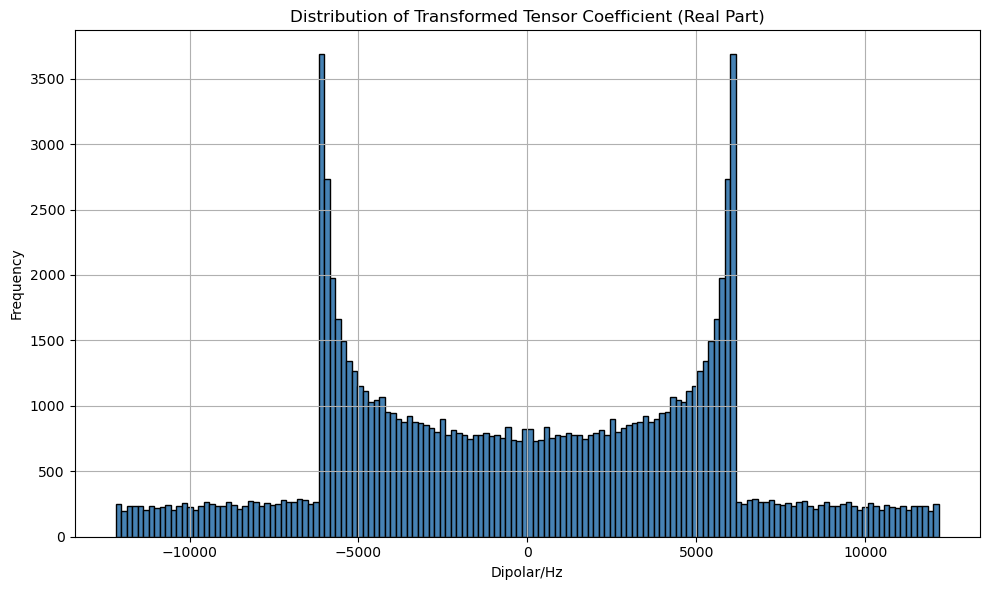

Monte Carlo integration result: 0.00 ppm


In [41]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import matplotlib.pyplot as plt

N = 50000
rot = R.random(num=N)        # random rotations
alpha_vals, beta_vals, gamma_vals = rot.as_euler('zyz', degrees=False).T


alpha, beta, gamma = sp.symbols('alpha beta gamma')

expr = D*T_rot[0]*np.sqrt(2/3)/2 # use your actual expression index here


expr_func = sp.lambdify((alpha, beta, gamma), expr, modules="numpy")

# Evaluate expr_func for each gamma and average
results = []
for a, b, g in zip(alpha_vals, beta_vals, gamma_vals):
    val_p = expr_func(a, b, g)
    val_m = - val_p
    results.append(((a, b, g), np.real(val_p)))  
    results.append(((a, b, g), np.real(val_m)))


# plot histogram
plt.figure(figsize=(10, 6))
plt.hist([val for _, val in results], bins=150, color='steelblue', edgecolor='black')
plt.title('Distribution of Transformed Tensor Coefficient (Real Part)')
plt.xlabel('Dipolar/Hz')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()
print(f"Monte Carlo integration result: {np.mean([val for _, val in results]):.2f} ppm")

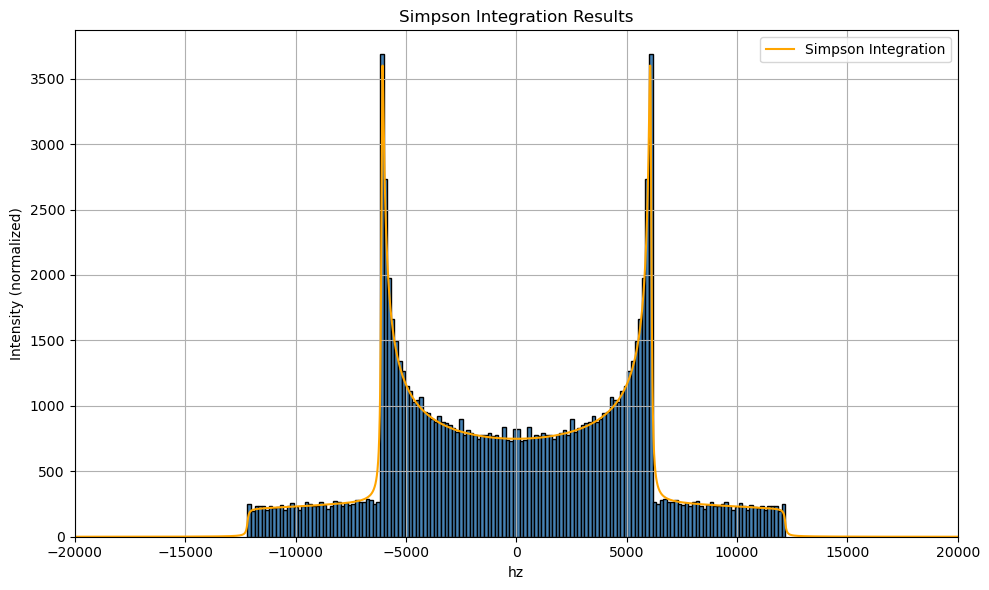

In [45]:
# compare with SIMPSON results

import pandas as pd

df1=pd.read_csv('/Users/yunyao_1/Dropbox/KcsA/analysis/simpson/HN_static.spe', skiprows=5, skipfooter=1, index_col=False,sep=' ',header=None,names=['real','image'],engine='python')
df1.real=df1.real-df1.real.min()  #baseline correction
df1.real=df1.real/df1.real.max()  #normalization

SW =40000
ref_ppm = 0
NP=8192
nuclus_freq= 1  # in Hz not ppm
span_ppm = SW/nuclus_freq # in Hz
start_x= ref_ppm-span_ppm/2
end_x= ref_ppm + span_ppm/2

x_axis =np.linspace(start_x, end_x, num= NP, endpoint=True)

#plot simpson results

plt.figure(figsize=(10, 6))
plt.plot(x_axis, df1.real*3600, label='Simpson Integration', color='orange')
# plot Monte Carlo results as bar plot
plt.hist([val for _, val in results], bins=150, color='steelblue', edgecolor='black')
plt.title('Simpson Integration Results')
plt.xlabel('hz')
plt.ylabel('Intensity (normalized)')
plt.xlim(start_x, end_x)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

## Part II. Order parameter calculation and autocorrelation

In [54]:
# read vetors of MD trajactory
# we will use CO bond as an example
import numpy as np
data = np.load("/Users/yunyao_1/Dropbox/KcsA/analysis/results/kcsa_5us_sigma_orientations.npz", allow_pickle=True)
sigma_33_dict = data['sigma_33'].item()  # Use `.item()` to extract the dictionary
sigma_22_dict = data['sigma_22'].item()
sigma_11_dict = data['sigma_11'].item()

# sigma_22 is along the CO bond
# convect bone vector to polar angle
# def a vector to polar function

def calculate_polar_angles(ori_t):
    """
    Calculate Polar angles from orientation matrices.

    Parameters:
        ori_t (np.ndarray): Orientation matrices, shape (num_frames, num_residues, 3).

    Returns:
        np.ndarray: Euler angles, shape (num_frames, num_residues, 2) for theta phi.
    """
    num_frames, num_residues = ori_t.shape[:2]
    polar_angles = np.zeros((num_frames, num_residues, 2))
    
    for frame in range(num_frames):
        for residue in range(num_residues):
            vector = ori_t[frame,residue]
    
            # Convert to Polar angle 
            polar_angles[frame, residue] = vector2polar(vector)
    
    return polar_angles

import numpy as np

def vector2polar(vec):
    """
    Convert a 3D vector to spherical coordinates (r, theta, phi).
    theta: polar angle (0 <= theta <= pi)
    phi: azimuthal angle (0 <= phi < 2*pi)
    """
    x, y, z = vec
    r = np.sqrt(x**2 + y**2 + z**2)
    if r == 0:
        theta = 0.0
        phi = 0.0
    else:
        theta = np.arccos(z / r)  # polar angle
        phi = np.arctan2(y, x)    # azimuthal angle
    return theta, phi

# calculate polar angles
polar_angles = {}
for chain in ['A', 'B', 'C', 'D']:
    polar_angles[chain] = calculate_polar_angles(sigma_22_dict[chain]) 

#

In [55]:
polar_angles['A'].shape# check the keys of the dictionary

(40001, 7, 2)

In [72]:
from scipy.special import sph_harm

def compute_sph_harm_autocorrelation_polar(polar_angles, l=2, m=0, max_window=10000):
    """
    Compute complex autocorrelation of Y_l^m spherical harmonics from vector trajectory.
    
    Parameters:
        polar_angle: (num_steps, 2) 
        l: degree of spherical harmonics
        m: order of spherical harmonics
        max_window: maximum time lag for autocorrelation

    Returns:
        corr: autocorrelation values
    """

    N = polar_angles.shape[0]

    if max_window > N:
        max_window = N

    theta = polar_angles[:,0]  # z = cos(theta)
    phi = polar_angles[:,1]

    Y_vals = sph_harm(m, l, phi, theta)

    corr = []
    for tau in range(max_window//10):
        if tau == 0:
            c = np.abs(np.mean(Y_vals * np.conj(Y_vals)))  # Normalization
        else:
            c = np.mean(Y_vals[:-tau] * np.conj(Y_vals[tau:]))
        corr.append(np.real(c))  # or keep complex values
    return np.array(corr)




In [3]:
# try chain A res_idx 2(76)

polar_test = polar_angles['A'][:, 2, :] # [frame, res, 2]
corr_test_0 = compute_sph_harm_autocorrelation_polar(polar_test, l=2, m=0, max_window=40000)
corr_test_1 = compute_sph_harm_autocorrelation_polar(polar_test, l=2, m=1, max_window=40000)
corr_test_2 = compute_sph_harm_autocorrelation_polar(polar_test, l=2, m=2, max_window=40000)
corr_test_sum = 4*np.pi/5*(corr_test_0 + corr_test_1*2 + corr_test_2*2)

time = np.arange(len(corr_test_0)) * 1e-10 # 100*10(-12) ps time step


from scipy.optimize import curve_fit

def correlation_model(t, S2, tau):
    return S2 + (1 - S2) * np.exp(-t / tau)

def fit_correlation_function(C_t, dt):
    t = np.arange(len(C_t)) * dt
    # Initial guesses: S2 ≈ C_t[-1], tau ≈ time when C_t drops to (1+S2)/2
    S2_guess = C_t[-1]
    half_max = (1 + S2_guess) / 2
    tau_guess = t[np.argmin(np.abs(C_t - half_max))] if np.any(C_t < half_max) else 0.01

    popt, pcov = curve_fit(correlation_model, t, C_t, p0=[S2_guess, tau_guess])
    S2_fit, tau_fit = popt
    return S2_fit, tau_fit, t, correlation_model(t, *popt)

# fit the correlation function
S2_fit, tau_fit, time_fit, C_fit = fit_correlation_function(corr_test_sum, dt=1e-10)

print(f"Fitted S² = {S2_fit:.4f}")
print(f"Fitted τ = {tau_fit*1e10:.5f} ns")

# plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(time*1e10, corr_test_0, label='m=0')
plt.plot(time*1e10, corr_test_1, label='m=1')
plt.plot(time*1e10, corr_test_2, label='m=2')
plt.plot(time*1e10, corr_test_sum, label='Sum m=0,1,2', linewidth=2, color='black')
plt.plot(time_fit*1e10, C_fit, label='Fitted Curve', linestyle='--', color='red')
plt.title('Spherical Harmonics Autocorrelation (Chain A, Res 76)')
plt.xlabel('Time (ns)')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()



NameError: name 'polar_angles' is not defined

### Q: will individual m correaltion show same tau and S**2

Ans: No!

Fitted S² for m=0 = 0.7835, τ = 111.20386 ps
Fitted S² for m=1 = 0.2217, τ = 156.83497 ps
Fitted S² for m=2 = 0.4643, τ = 178.66315 ps


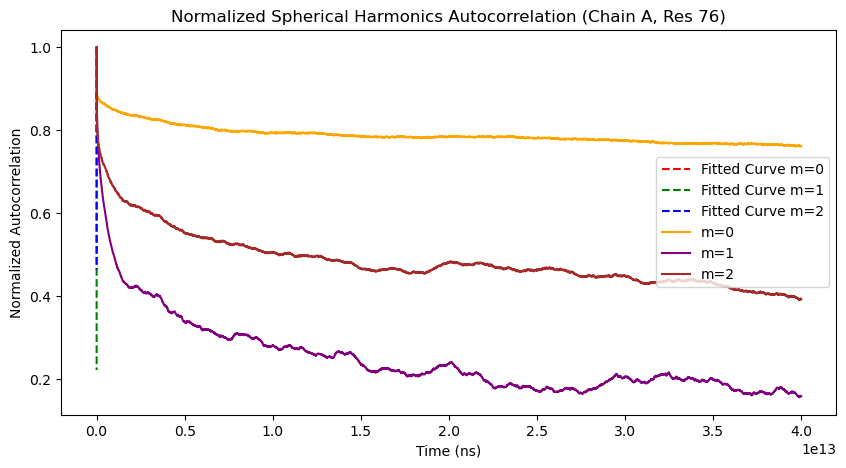

In [84]:
# a samll test: whether we could fit tau and S2 from the normailized m=0 1 or 2 aucorrelation

# generate the normalized autocorrelation function
corr_test_0 = corr_test_0 / np.max(corr_test_0)
corr_test_1 = corr_test_1 / np.max(corr_test_1)
corr_test_2 = corr_test_2 / np.max(corr_test_2)

# fit the normalized autocorrelation function
S2_fit_0, tau_fit_0, time_fit_0, C_fit_0 = fit_correlation_function(corr_test_0, dt=1e-10)
S2_fit_1, tau_fit_1, time_fit_1, C_fit_1 = fit_correlation_function(corr_test_1, dt=1e-10)
S2_fit_2, tau_fit_2, time_fit_2, C_fit_2 = fit_correlation_function(corr_test_2, dt=1e-10)          
print(f"Fitted S² for m=0 = {S2_fit_0:.4f}, τ = {tau_fit_0*1e10:.5f} ps")
print(f"Fitted S² for m=1 = {S2_fit_1:.4f}, τ = {tau_fit_1*1e10:.5f} ps")   
print(f"Fitted S² for m=2 = {S2_fit_2:.4f}, τ = {tau_fit_2*1e10:.5f} ps")
# plot the normalized autocorrelation function and fitted curve
plt.figure(figsize=(10, 5))
plt.plot(time_fit_0*1e10, C_fit_0, label='Fitted Curve m=0', linestyle='--', color='red')
plt.plot(time_fit_1*1e10, C_fit_1, label='Fitted Curve m=1', linestyle='--', color='green')
plt.plot(time_fit_2*1e10, C_fit_2, label='Fitted Curve m=2', linestyle='--', color='blue')  
plt.plot(time*1e10, corr_test_0, label='m=0', color='orange')
plt.plot(time*1e10, corr_test_1, label='m=1', color='purple')
plt.plot(time*1e10, corr_test_2, label='m=2', color='brown')
plt.title('Normalized Spherical Harmonics Autocorrelation (Chain A, Res 76)')
plt.xlabel('Time (ns)')
plt.ylabel('Normalized Autocorrelation')
plt.legend()
plt.show()

In [76]:
# now expand the results to all residue and chains and save results
all_results = {}
for chain in polar_angles:
    all_results[chain] = []
    for res_idx in range(polar_angles[chain].shape[1]):
        polar_test = polar_angles[chain][:, res_idx, :] # [frame, res, 2]
        corr_0 = compute_sph_harm_autocorrelation_polar(polar_test, l=2, m=0, max_window=40000)
        corr_1 = compute_sph_harm_autocorrelation_polar(polar_test, l=2, m=1, max_window=40000)
        corr_2 = compute_sph_harm_autocorrelation_polar(polar_test, l=2, m=2, max_window=40000)
        corr_sum = 4*np.pi/5*(corr_0 + corr_1*2 + corr_2*2)
        
        S2_fit, tau_fit, time_fit, C_fit = fit_correlation_function(corr_sum, dt=1e-10)
        
        all_results[chain].append({
            'res_idx': res_idx,
            'S2': S2_fit,
            'tau': tau_fit,
            'time': time_fit,
            'C_t': corr_sum
        })

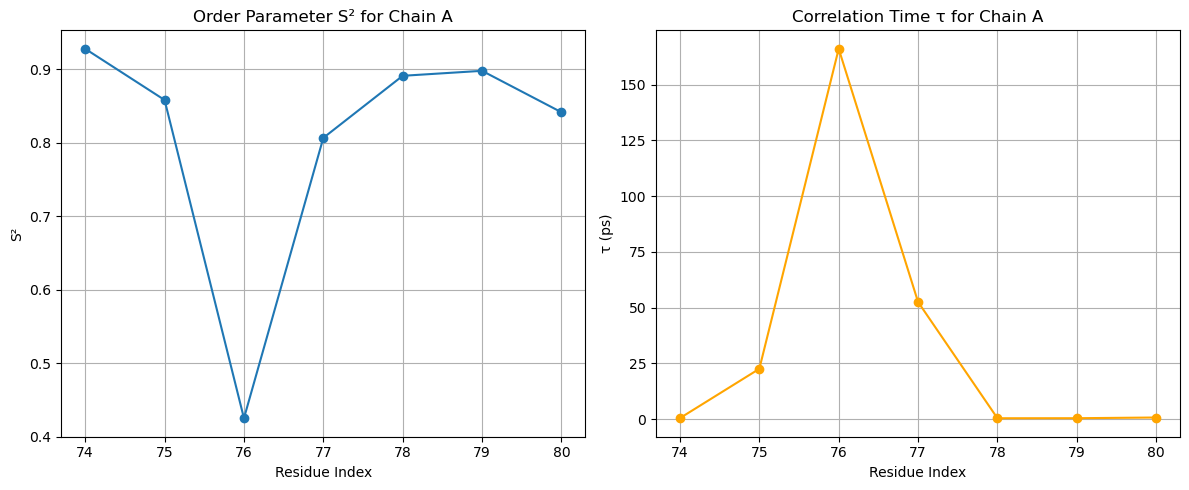

In [78]:
# plot the tau and S2 values for all residues in chain A
chain = 'A'
res_indices = [res['res_idx']+74 for res in all_results[chain]]
S2_values = [res['S2'] for res in all_results[chain]]
tau_values = [res['tau']*1e10 for res in all_results[chain]] # convert to ps    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(res_indices, S2_values, marker='o')
plt.title('Order Parameter S² for Chain A')
plt.xlabel('Residue Index')
plt.ylabel('S²')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(res_indices, tau_values, marker='o', color='orange')
plt.title('Correlation Time τ for Chain A')
plt.xlabel('Residue Index')
plt.ylabel('τ (ps)')
plt.grid(True)
plt.tight_layout()
plt.show()

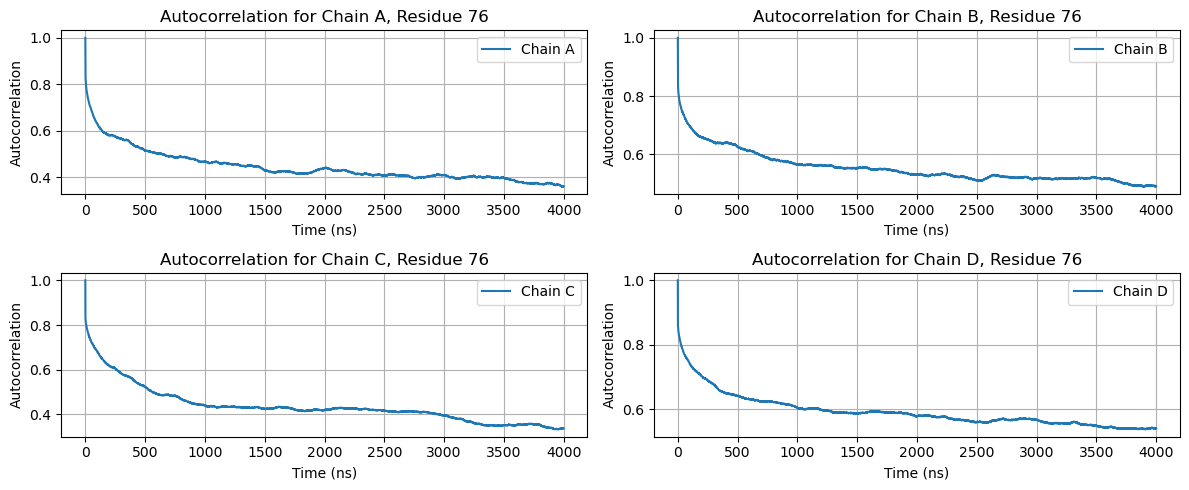

In [89]:
# plot for all chaisn for residue 76 (index 2)
res_idx = 2
plt.figure(figsize=(12, 5))
for i, chain in enumerate(all_results):
    res = all_results[chain][res_idx]
    time = res['time']*1e10  # convert to ps
    C_t = res['C_t']
    plt.subplot(2, 2, i+1)
    plt.plot(time, C_t, label=f'Chain {chain}')
    plt.title(f'Autocorrelation for Chain {chain}, Residue {res_idx+74}')
    plt.xlabel('Time (ns)')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show() 

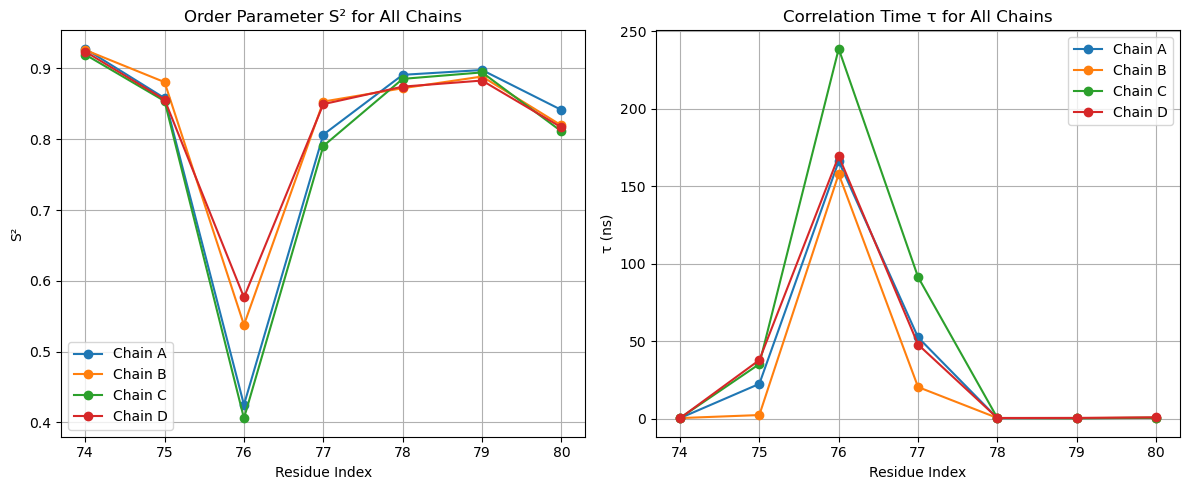

In [90]:
# show the S2 and tau values for all chains 
S2_values = {chain: [res['S2'] for res in all_results[chain]] for chain in all_results}
tau_values = {chain: [res['tau'] for res in all_results[chain]] for chain in all_results}   
# plot S2 and tau values for all chains
# shift the residue index to start from 74
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
idx=range(74, 74 + len(S2_values['A']))  # residue indices starting from 74
for chain in S2_values:
    plt.plot(S2_values[chain], marker='o', label=f'Chain {chain}')
plt.xticks(ticks=range(len(idx)), labels=idx)
plt.title('Order Parameter S² for All Chains')      
plt.xlabel('Residue Index')
plt.ylabel('S²')
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
for chain in tau_values:
    plt.plot([tau * 1e10 for tau in tau_values[chain]], marker='o', label=f'Chain {chain}')  # convert to ps
plt.xticks(ticks=range(len(idx)), labels=idx)
plt.title('Correlation Time τ for All Chains')
plt.xlabel('Residue Index')
plt.ylabel('τ (ns)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()  

### Fit V76 autocorrelation time with more parameters

In [2]:
# build a model with S2 and tau as parameters
from scipy.optimize import curve_fit

# build a model with fast and slow dynamics
def correlation_model2(t, S2_s, tau_s, S2_f, tau_f):
    return S2_s*(S2_f + (1 - S2_f) * np.exp(-t / tau_f))+(1-S2_s)*np.exp(-t / tau_s)

# fit the correlation function with the new model
def fit_correlation_function2(C_t, dt): 
    t = np.arange(len(C_t)) * dt
    # Initial guesses: S2_s ≈ C_t[-1], tau_s ≈ time when C_t drops to (1+S2_s)/2
    S2_s_guess = C_t[-1]
    half_max = (1 + S2_s_guess) / 2
    tau_s_guess = t[np.argmin(np.abs(C_t - half_max))] if np.any(C_t < half_max) else 0.01
    
    # For the fast component, we can use the same guess for S2_f and tau_f
    S2_f_guess = 0.5  # initial guess for fast component
    tau_f_guess = dt # initial guess for fast component

    popt, pcov = curve_fit(correlation_model2, t, C_t, p0=[S2_s_guess, tau_s_guess, S2_f_guess, tau_f_guess])
    S2_s_fit, tau_s_fit, S2_f_fit, tau_f_fit = popt
    return S2_s_fit, tau_s_fit, S2_f_fit, tau_f_fit, t, correlation_model2(t, *popt)

# fit the correlation function with the new model
# dt should be 1e-9 as in correlation function, we //10 mean the time step now is 1e-9
S2_s_fit, tau_s_fit, S2_f_fit, tau_f_fit, time_fit, C_fit = fit_correlation_function2(corr_test_sum, dt=1e-9)  
print(f"Fitted S²_s = {S2_s_fit:.4f}, τ_s = {tau_s_fit*1e10:.5f} ns")
print(f"Fitted S²_f = {S2_f_fit:.4f}, τ_f = {tau_f_fit*1e10:.5f} ns")
# plot the fitted curve
time = np.arange(len(corr_test_sum)) * 1e-9
plt.figure(figsize=(10, 5))
plt.plot(time*1e9, corr_test_sum, label='Autocorrelation', color='blue')
plt.plot(time_fit*1e9, C_fit, label='Fitted Curve', linestyle='--', color='red')
plt.title('Fitted Autocorrelation with Fast and Slow Dynamics')
plt.xlabel('Time (ns)')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()  


    
    

NameError: name 'corr_test_sum' is not defined